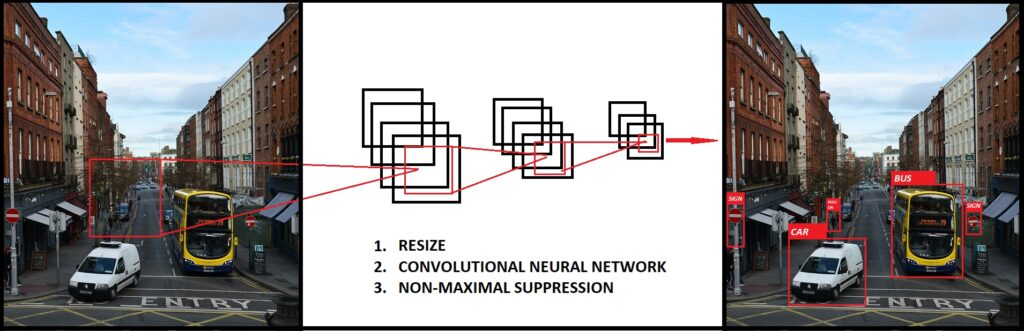

<center>
    
    
 ## Replicating YOLOv2 CNN Architecture
    
___

<center>

##### Pablo de la Asunción Cumbrera Conde

### Índice

- Introducción
- Librerias (Modelo, utilidad, conversión y entrenamiento)

- 0. Definición de funciones misceláneas para variar parámetros
- 1. Definición de las funciones del modelo
- 2. Definición de las funciones de utilidad
- 3. Definición de la función de conversión
- 4. Definición de la función de detección
- 5. Definición de la función de detección de video
- 6. Definición de la función de entrenamiento
- 7. Definición de las funciones Data Set (nombre original)

- Compilación del Modelo
- Prueba y evaluación del Modelo
- Conclusiones

####  Introducción
___

#### ¿Qué es YOLO?

YOLO (You Only Look Once)es un modelo de Deep Learning de código abierto para detección de objetos en tiempo real, el cual hace uso de una única red neuronal convolucional para detectar objetos en imágenes.

En la imagen podemos ver una versión reducida del algoritmo (Tiny YOLO).

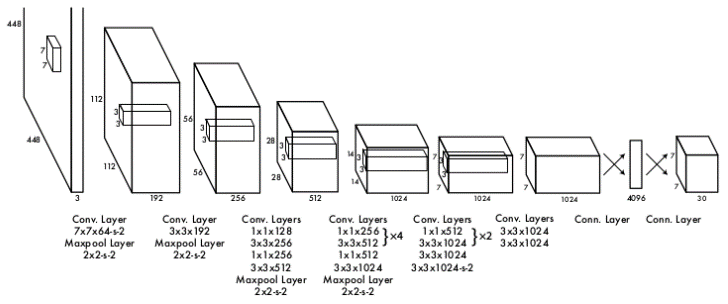

#### ¿Cómo funciona YOLO?

Para su funcionamiento, YOLO divide la imagen en un grid 13x13, siendo cada una de estas divisiones encargadas de predecir 5 bounding boxes (845 en total) prediciendo cuadros de identificación y probabilidades por cada región. Las cajas son ponderadas a partir de las probabilidades predichas. El algoritmo aprende representaciones generalizables de los objetos, permitiendo un bajo error de detección para entradas nuevas (stardart threshold=30%) diferentes al conjunto de datos de entrenamiento.

Todas estas predicciones 845, se realizaron al mismo tiempo. Por ello el algoritmo recibe el nombre de 'You Only Look Once'.

En la imagen a continuación podemos observar estos pasos.
1. Grid 2.Bounding Boxes 3.Non max supression

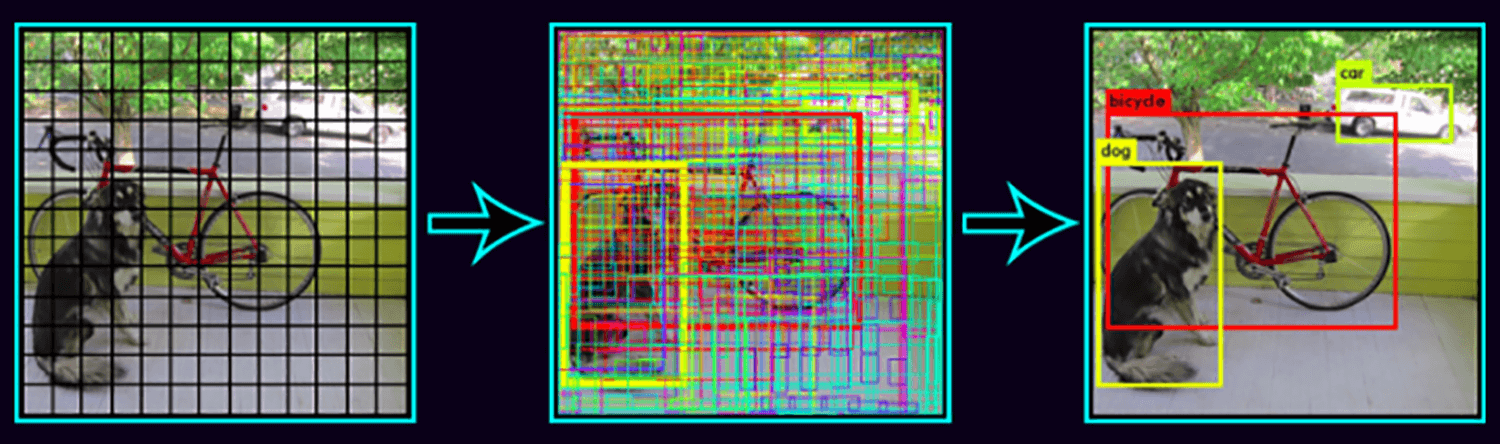

#### Arquitectura del modelo:

- El modelo original tiene 53 capas convolucionales (Darknet 53)

- El modelo Tiny se compone de 24 capas convolucionales y 2 capas full conected.
 
- El output es un tensor 13x13x125 (13x13 matriz en que divide la imagen) y 125 son los datos que contienen cada una de las 5 bounding boxes de cada celda:
    - [x, y, w, h] Which are: x [0,1] , y [0,1], height and width for the bounding box rectangle
    - Probability distribution over the classes (Probability that there is an object in the cell, and which class is it
    - Confidence Score

- En Yolov3 las tres salidas que observamos en la imagen se corresponden con 13x13, 26x26 y 52x52 respectivamente para tres diferentes escalas.

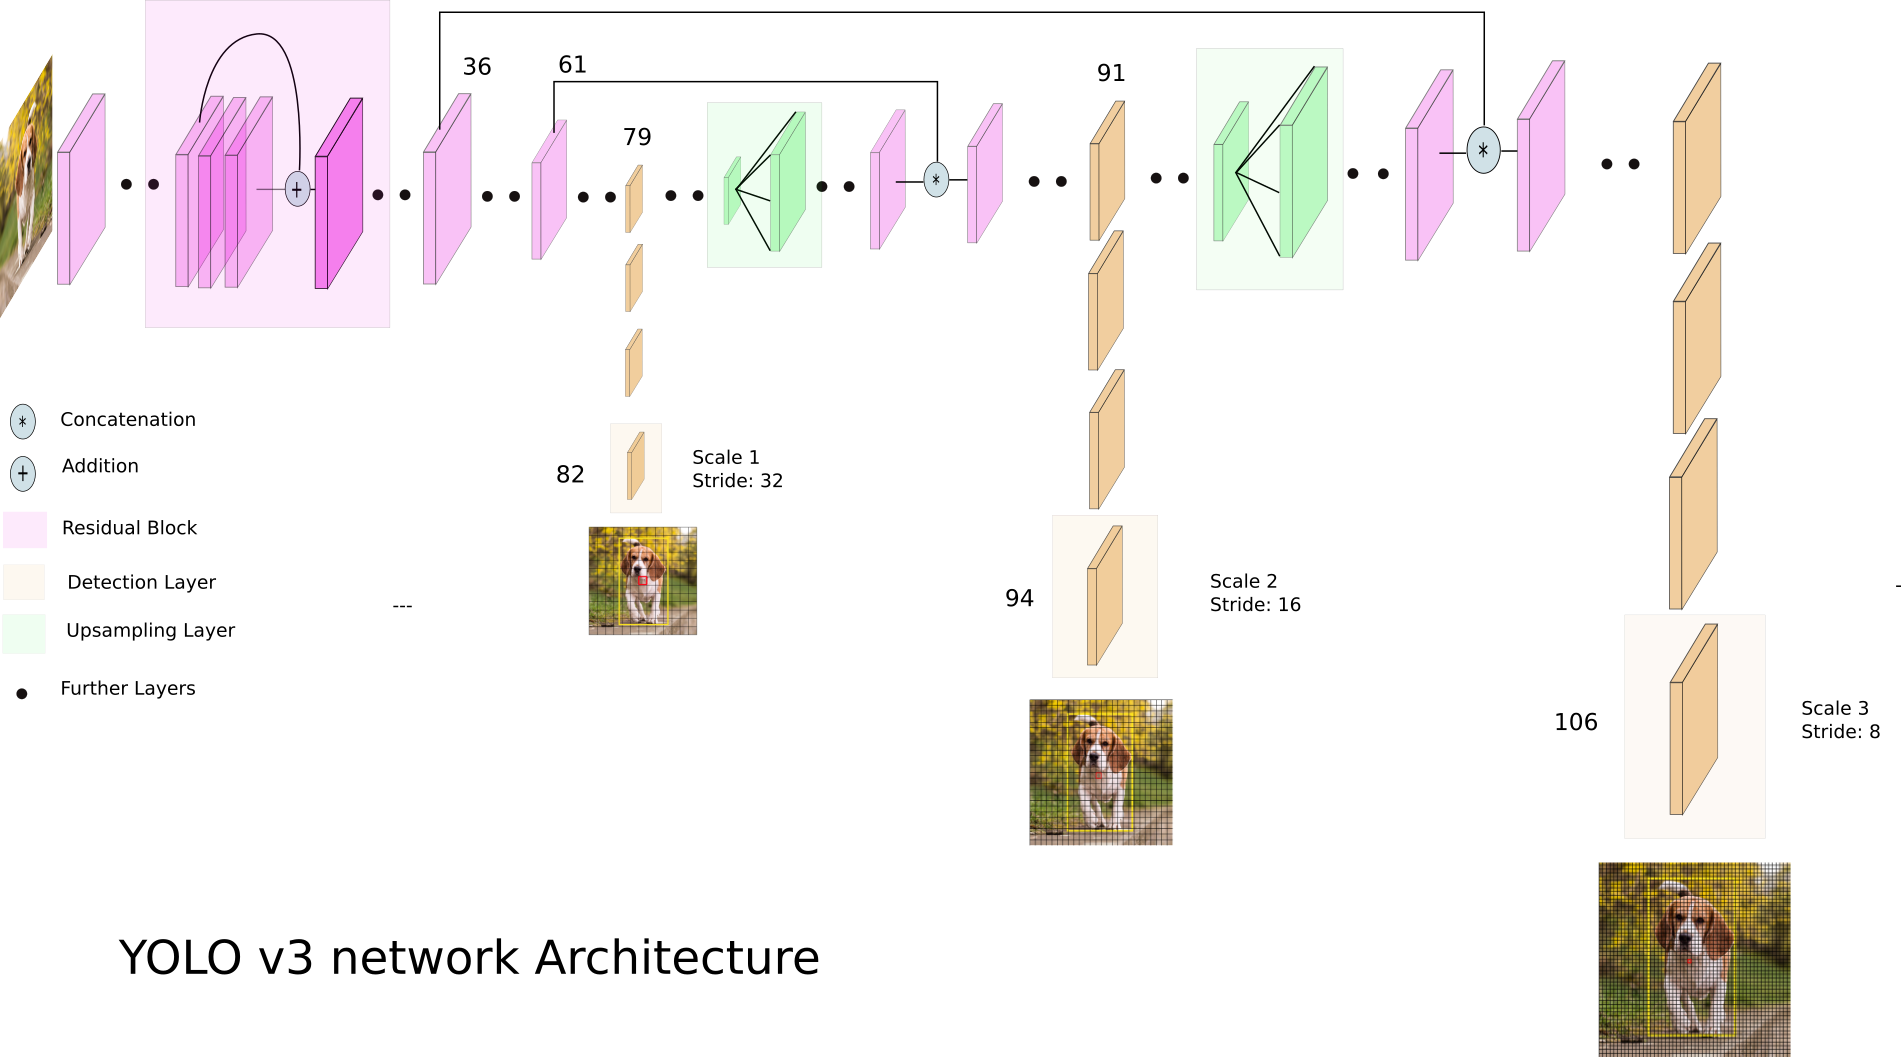

#### YOLO Training

- El modelo ha sido pre entrenado con el Data Set COCO (Common Objects in Context): https://cocodataset.org/

    - 121,408 Imagenes
    - 883,331 anotaciones de objetos
    - 80 clases
    - 640x480 median image ratio

#### Fuente:
- Contenido bibliográfico:
    - https://pjreddie.com/media/files/papers/YOLOv3.pdf
    
    - https://blog.zenggyu.com/en/post/2018-12-16/an-introduction-to-evaluation-metrics-for-object-detection/
                         
- Contenido técnico:
    - https://github.com/zzh8829/yolov3-tf2 - 
        Autor: 'Zihao Zhang' Email: 'zzh8829@gmail.com',

#### Librerías
___

- Librerias para definir el modelo

In [1]:
from absl import flags
from absl.flags import FLAGS
import numpy as np
import tensorflow as tf
import visualkeras
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    LeakyReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
    BatchNormalization,
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (
    binary_crossentropy,
    sparse_categorical_crossentropy
)

- Librerias para definir la detección

In [2]:
import time
from absl import app, flags, logging
import cv2
#from yolov3_tf2.models import YoloV3
#from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
#from yolov3_tf2.utils import draw_outputs

- Librerias para definir la conversión

In [3]:
#from absl import app, flags, logging
#from absl.flags import FLAGS
#import numpy as np
#from yolov3_tf2.models import YoloV3
#from yolov3_tf2.utils import load_darknet_weights

- Librerias para definir el entrenamiento

In [4]:
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)
#from yolov3_tf2.models import (
    #YoloV3, YoloV3Tiny, YoloLoss,
   # yolo_anchors, yolo_anchor_masks,
   # yolo_tiny_anchors, yolo_tiny_anchor_masks)
    
#from yolov3_tf2.utils import freeze_all
#import yolov3_tf2.dataset as dataset

#### 0. Definición funciones misceláneas para variar parámetros
___

- 0. A

In [5]:
max_boxes=100
iou_threshold=0.5
score_threshold=0.5
path_data=''
path_val_data=''
batch_size_flag=8
weights_num_classes=None
learning_rate_flag=1e-3
epochs_flag=2
video_output_format = 'XVID'
path_files= r'C:\Users\pablo.cumbrera\Downloads\yolov3-tf2-master\yolov3-tf2-master\data\coco.names'
path_weights= r'C:\Users\pablo.cumbrera\Downloads\yolov3-tf2-master\yolov3-tf2-master\checkpoints\yolov3.tf'
resize_img= 416
path_img= r'C:\Users\pablo.cumbrera\Downloads\yolov3-tf2-master\yolov3-tf2-master\data\girl.png'
path_video= r'C:\Users\pablo.cumbrera\Downloads\yolov3-tf2-master\yolov3-tf2-master\data\video.mp4'
tiny_flag=False
tfrecord_flag = None
video_path_output=r'C:\Users\pablo.cumbrera\Downloads\yolov3-tf2-master\yolov3-tf2-master\outputs\video-output.mp4'
path_output= r'C:\Users\pablo.cumbrera\Downloads\yolov3-tf2-master\yolov3-tf2-master\outputs\output.jpg'
num_classes=80


transfer_flag =  None
                #['none', 'darknet', 'no_output', 'frozen', 'fine_tune'],
                  #'none: Training from scratch, '
                  #'darknet: Transfer darknet, '
                  #'no_output: Transfer all but output, '
                  #'frozen: Transfer and freeze all, '
                  #'fine_tune: Transfer all and freeze darknet only'
                
                
                
mode_flag = 'fit'
#['fit', 'eager_fit', 'eager_tf'],
                  #'fit: model.fit, '
                  #'eager_fit: model.fit(run_eagerly=True), '
                  #'eager_tf: custom GradientTape')
#flags.DEFINE_enum('transfer', 'none',

#### 1. Definición de funciones del modelo
___

In [6]:
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                         (59, 119), (116, 90), (156, 198), (373, 326)],
                        np.float32) / 416
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

yolo_tiny_anchors = np.array([(10, 14), (23, 27), (37, 58),
                              (81, 82), (135, 169),  (344, 319)],
                             np.float32) / 416
yolo_tiny_anchor_masks = np.array([[3, 4, 5], [0, 1, 2]])

- 1. A

In [7]:
max_boxes=100
iou_threshold=0.5
score_threshold=0.5
path_data=''
path_val_data=''
batch_size_flag=8
weights_num_classes=None
learning_rate_flag=1e-3
epochs_flag=2
path_files= r'C:\Users\pablo.cumbrera\Downloads\yolov3-tf2-master\yolov3-tf2-master\data\coco.names'
path_weights= r'C:\Users\pablo.cumbrera\Downloads\yolov3-tf2-master\yolov3-tf2-master\checkpoints\yolov3.tf'
resize_img= 416
path_img= r'C:\Users\pablo.cumbrera\Downloads\yolov3-tf2-master\yolov3-tf2-master\data\girl.png'
tiny_flag=False
tfrecord_flag = None
path_output= r'C:\Users\pablo.cumbrera\Downloads\yolov3-tf2-master\yolov3-tf2-master\outputs\output.jpg'
num_classes=80


transfer_flag =  None
                #['none', 'darknet', 'no_output', 'frozen', 'fine_tune'],
                  #'none: Training from scratch, '
                  #'darknet: Transfer darknet, '
                  #'no_output: Transfer all but output, '
                  #'frozen: Transfer and freeze all, '
                  #'fine_tune: Transfer all and freeze darknet only'
                
                
                
mode_flag = 'fit'
#['fit', 'eager_fit', 'eager_tf'],
                  #'fit: model.fit, '
                  #'eager_fit: model.fit(run_eagerly=True), '
                  #'eager_tf: custom GradientTape')
#flags.DEFINE_enum('transfer', 'none',

- 1. B

In [8]:
def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)  # skip connection
    x = x_36 = DarknetBlock(x, 256, 8)  # skip connection
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)

- 1. C

In [9]:
def DarknetBlock(x, filters, blocks):
    x = DarknetConv(x, filters, 3, strides=2)
    for _ in range(blocks):
        x = DarknetResidual(x, filters)
    return x

- 1. D

In [10]:
def DarknetConv(x, filters, size, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=size,
               strides=strides, padding=padding,
               use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x

- 1. E

In [11]:
def DarknetResidual(x, filters):
    prev = x
    x = DarknetConv(x, filters // 2, 1)
    x = DarknetConv(x, filters, 3)
    x = Add()([prev, x])
    return x

- 1. F

In [12]:
def YoloConv(filters, name=None): 
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv

- 1. G

In [13]:
def YoloOutput(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                            anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output

- 1. H

In [14]:
def _meshgrid(n_a, n_b):

    return [
        tf.reshape(tf.tile(tf.range(n_a), [n_b]), (n_b, n_a)),
        tf.reshape(tf.repeat(tf.range(n_b), n_a), (n_b, n_a))
    ]

- 1. I

In [15]:
def yolo_boxes(pred, anchors, classes):
    # pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))
    grid_size = tf.shape(pred)[1:3]
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)

    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss

    # !!! grid[x][y] == (y, x)
    grid = _meshgrid(grid_size[1],grid_size[0])
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]

    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)

    return bbox, objectness, class_probs, pred_box

- 1. J

In [16]:
def yolo_nms(outputs, anchors, masks, classes):
    max_boxes = 100
    iou_threshold = 0.5
    score_threshold = 0.5
    # boxes, conf, type
    b, c, t = [], [], []

    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))

    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)

    scores = confidence * class_probs

    dscores = tf.squeeze(scores, axis=0)
    scores = tf.reduce_max(dscores,[1])
    bbox = tf.reshape(bbox,(-1,4))
    classes = tf.argmax(dscores,1)
    selected_indices, selected_scores = tf.image.non_max_suppression_with_scores(
        boxes=bbox,
        scores=scores,
        max_output_size=max_boxes,
        iou_threshold=iou_threshold,
        score_threshold=score_threshold,
        soft_nms_sigma=0.5
    )
    
    num_valid_nms_boxes = tf.shape(selected_indices)[0]

    selected_indices = tf.concat([selected_indices,tf.zeros(max_boxes-num_valid_nms_boxes, tf.int32)], 0)
    selected_scores = tf.concat([selected_scores,tf.zeros(max_boxes-num_valid_nms_boxes,tf.float32)], -1)

    boxes=tf.gather(bbox, selected_indices)
    boxes = tf.expand_dims(boxes, axis=0)
    scores=selected_scores
    scores = tf.expand_dims(scores, axis=0)
    classes = tf.gather(classes,selected_indices)
    classes = tf.expand_dims(classes, axis=0)
    valid_detections=num_valid_nms_boxes
    valid_detections = tf.expand_dims(valid_detections, axis=0)

    return boxes, scores, classes, valid_detections

- 1. K

In [17]:
def YoloV3(size=None, channels=3, anchors=yolo_anchors,
           masks=yolo_anchor_masks, classes=80, training=False):
    x = inputs = Input([size, size, channels], name='input')

    x_36, x_61, x = Darknet(name='yolo_darknet')(x)

    x = YoloConv(512, name='yolo_conv_0')(x)
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)

    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

    if training:
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')

    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                     name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                     name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                     name='yolo_boxes_2')(output_2)

    outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, classes),
                     name='yolo_nms')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

    return Model(inputs, outputs, name='yolov3')

- 1. L

In [18]:
def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
        # 1. transform all pred outputs
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(
            y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]

        # 2. transform all true outputs
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]

        # give higher weights to small boxes
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

        # 3. inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh),
                           tf.zeros_like(true_wh), true_wh)

        # 4. calculate all masks
        obj_mask = tf.squeeze(true_obj, -1)
        # ignore false positive when iou is over threshold
        best_iou = tf.map_fn(
            lambda x: tf.reduce_max(broadcast_iou(x[0], tf.boolean_mask(
                x[1], tf.cast(x[2], tf.bool))), axis=-1),
            (pred_box, true_box, obj_mask),
            tf.float32)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        # 5. calculate all losses
        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss
        # TODO: use binary_crossentropy instead
        class_loss = obj_mask * sparse_categorical_crossentropy(
            true_class_idx, pred_class)

        # 6. sum over (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss

#### 2. Definición de las funciones de utilidad
___

- 2. A

In [19]:
YOLOV3_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
    'yolo_conv_2',
    'yolo_output_2',
]

YOLOV3_TINY_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
]

- 2. B

In [20]:
def load_darknet_weights(model, weights_file, tiny=False):
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

    if tiny:
        layers = YOLOV3_TINY_LAYER_LIST
    else:
        layers = YOLOV3_LAYER_LIST

    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and \
                    sub_model.layers[i + 1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i + 1]

            logging.info("{}/{} {}".format(
                sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))

            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.get_input_shape_at(0)[-1]

            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                # darknet [beta, gamma, mean, variance]
                bn_weights = np.fromfile(
                    wf, dtype=np.float32, count=4 * filters)
                # tf [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

            # darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(
                wf, dtype=np.float32, count=np.product(conv_shape))
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])

            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)

    assert len(wf.read()) == 0, 'failed to read all data'
    wf.close()

- 2. C

In [21]:
def broadcast_iou(box_1, box_2):
    # box_1: (..., (x1, y1, x2, y2))
    # box_2: (N, (x1, y1, x2, y2))

    # broadcast boxes
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)
    # new_shape: (..., N, (x1, y1, x2, y2))
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape)
    box_2 = tf.broadcast_to(box_2, new_shape)

    int_w = tf.maximum(tf.minimum(box_1[..., 2], box_2[..., 2]) -
                       tf.maximum(box_1[..., 0], box_2[..., 0]), 0)
    int_h = tf.maximum(tf.minimum(box_1[..., 3], box_2[..., 3]) -
                       tf.maximum(box_1[..., 1], box_2[..., 1]), 0)
    int_area = int_w * int_h
    box_1_area = (box_1[..., 2] - box_1[..., 0]) * \
        (box_1[..., 3] - box_1[..., 1])
    box_2_area = (box_2[..., 2] - box_2[..., 0]) * \
        (box_2[..., 3] - box_2[..., 1])
    return int_area / (box_1_area + box_2_area - int_area)

- 2. D

In [22]:
def draw_outputs(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img

- 2. E

In [23]:
def draw_labels(x, y, class_names):
    img = x.numpy()
    boxes, classes = tf.split(y, (4, 1), axis=-1)
    classes = classes[..., 0]
    wh = np.flip(img.shape[0:2])
    for i in range(len(boxes)):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, class_names[classes[i]],
                          x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL,
                          1, (0, 0, 255), 2)
    return img

- 2. F

In [24]:
def freeze_all(model, frozen=True):
    model.trainable = not frozen
    if isinstance(model, tf.keras.Model):
        for l in model.layers:
            freeze_all(l, frozen)

#### 3. Definición de la funcion de conversión
___

- 3. A

In [25]:
def mainB(_argv):

    yolo = YoloV3(classes=num_classes)
    yolo.summary()
    logging.info('model created')

    load_darknet_weights(yolo, path_weights)
    logging.info('weights loaded')

    img = np.random.random((1, 320, 320, 3)).astype(np.float32)
    output = yolo(img)
    logging.info('sanity check passed')

    yolo.save_weights(path_output)
    logging.info('weights saved')


if __name__ == '__main__':
    try:
        app.run(mainB)
    except SystemExit:
        pass

FATAL Flags parsing error: Unknown command line flag 'f'
Pass --helpshort or --helpfull to see help on flags.


- 3. B

#### 4. Definición de la función de detección
___

- 4. A

In [26]:
def mainA(_argv):
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    for physical_device in physical_devices:
        tf.config.experimental.set_memory_growth(physical_device, True)

    if tiny_flag:
        yolo = YoloV3Tiny(classes=num_classes)
    else:
        yolo = YoloV3(classes=num_classes)

    yolo.load_weights(path_weights).expect_partial()
    logging.info('weights loaded')

    class_names = [c.strip() for c in open(path_files).readlines()]
    logging.info('classes loaded')

    if tfrecord_flag:
        dataset = load_tfrecord_dataset(
            tfrecord_flag, path_files, resize_img)
        dataset = dataset.shuffle(512)
        img_raw, _label = next(iter(dataset.take(1)))
    else:
        img_raw = tf.image.decode_image(
            open(path_img, 'rb').read(), channels=3)

    img = tf.expand_dims(img_raw, 0)
    img = transform_images(img, resize_img)

    t1 = time.time()
    boxes, scores, classes, nums = yolo(img)
    t2 = time.time()
    logging.info('time: {}'.format(t2 - t1))

    logging.info('detections:')
    for i in range(nums[0]):
        logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                           np.array(scores[0][i]),
                                           np.array(boxes[0][i])))

    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
    cv2.imwrite(path_output, img)
    logging.info('output saved to: {}'.format(path_output))


if __name__ == '__main__':
    try:
        app.run(mainB)
    except SystemExit:
        pass

FATAL Flags parsing error: Unknown command line flag 'f'
Pass --helpshort or --helpfull to see help on flags.


#### 5. Definición de las funciones de detección de video
___

- 5. A

In [27]:
#Flags del modelo original sustituidas en funciones posteriores

#flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
#flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    #'path to weights file')
#flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
#flags.DEFINE_integer('size', 416, 'resize images to')
#flags.DEFINE_string('video', './data/video.mp4',
                    #'path to video file or number for webcam)')
#flags.DEFINE_string('output', None, 'path to output video')
#flags.DEFINE_string('output_format', 'XVID', 'codec used in VideoWriter when saving video to file')
#flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

- 5. B

In [28]:
def mainC(_argv):
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    for physical_device in physical_devices:
        tf.config.experimental.set_memory_growth(physical_device, True)

    if tiny_flag:
        yolo = YoloV3Tiny(classes=num_classes)
    else:
        yolo = YoloV3(classes=num_classes)

    yolo.load_weights(path_weights)
    logging.info('weights loaded')

    class_names = [c.strip() for c in open(path_files).readlines()]
    logging.info('classes loaded')

    times = []

    try:
        vid = cv2.VideoCapture(int(path_video))
    except:
        vid = cv2.VideoCapture(path_video)

    out = None

    if video_path_output:
        # by default VideoCapture returns float instead of int
        width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(vid.get(cv2.CAP_PROP_FPS))
        codec = cv2.VideoWriter_fourcc(*video_output_format) ## Atento aqui a este asteristo
        out = cv2.VideoWriter(video_path_output, codec, fps, (width, height))

    while True:
        _, img = vid.read()

        if img is None:
            logging.warning("Empty Frame")
            time.sleep(0.1)
            continue

        img_in = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_in = tf.expand_dims(img_in, 0)
        img_in = transform_images(img_in, resize_img)

        t1 = time.time()
        boxes, scores, classes, nums = yolo.predict(img_in)
        t2 = time.time()
        times.append(t2-t1)
        times = times[-20:]

        img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
        img = cv2.putText(img, "Time: {:.2f}ms".format(sum(times)/len(times)*1000), (0, 30),
                          cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
        if video_path_output:
            out.write(img)
        cv2.imshow('output', img)
        if cv2.waitKey(1) == ord('q'):
            break

    cv2.destroyAllWindows()


if __name__ == '__main__':
    try:
        app.run(mainC)
    except SystemExit:
        pass

FATAL Flags parsing error: Unknown command line flag 'f'
Pass --helpshort or --helpfull to see help on flags.


#### 6. Definición de la función de entrenamiento
___

- 6. A

In [29]:
#Flags del modelo original sustituidas en la siguiente funcion

#flags.DEFINE_string('dataset', '', 'path to dataset')
#flags.DEFINE_string('val_dataset', '', 'path to validation dataset')
#flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
#flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    #'path to weights file')
#flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
#flags.DEFINE_enum('mode', 'fit', ['fit', 'eager_fit', 'eager_tf'],
              #    'fit: model.fit, '
              #    'eager_fit: model.fit(run_eagerly=True), '
              #    'eager_tf: custom GradientTape')

#transfer_flag =  ['none', 'darknet', 'no_output', 'frozen', 'fine_tune'],
                  #'none: Training from scratch, '
                  #'darknet: Transfer darknet, '
                  #'no_output: Transfer all but output, '
                  #'frozen: Transfer and freeze all, '
                  #'fine_tune: Transfer all and freeze darknet only')
#flags.DEFINE_integer('size', 416, 'image size')
#flags.DEFINE_integer('epochs', 2, 'number of epochs')
#flags.DEFINE_float('learning_rate', 1e-3, 'learning rate')
#flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')
#flags.DEFINE_integer('weights_num_classes', None, 'specify num class for `weights` file if different, '
                     #'useful in transfer learning with different number of classes')

- 6. B

In [30]:
def mainD(_argv):
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    for physical_device in physical_devices:
        tf.config.experimental.set_memory_growth(physical_device, True)

    if tiny_flag:
        model = YoloV3Tiny(resize_img, training=True,
                           classes=num_classes)
        anchors = yolo_tiny_anchors
        anchor_masks = yolo_tiny_anchor_masks
    else:
        model = YoloV3(resize_img, training=True, classes=num_classes)
        anchors = yolo_anchors
        anchor_masks = yolo_anchor_masks

    if path_data:
        train_dataset = dataset.load_tfrecord_dataset(
            path_data, path_files, resize_img)
    else:
        train_dataset = load_fake_dataset()
    train_dataset = train_dataset.shuffle(buffer_size=512)
    train_dataset = train_dataset.batch(batch_size_flag)
    train_dataset = train_dataset.map(lambda x, y: (
        transform_images(x, resize_img),
        transform_targets(y, anchors, anchor_masks, resize_img)))
    train_dataset = train_dataset.prefetch(
        buffer_size=tf.data.experimental.AUTOTUNE)

    if path_val_data:
        val_dataset = load_tfrecord_dataset(
            path_val_data, path_files, resize_img)
    else:
        val_dataset = load_fake_dataset()
    val_dataset = val_dataset.batch(batch_size_flag)
    val_dataset = val_dataset.map(lambda x, y: (
        transform_images(x, resize_img),
        transform_targets(y, anchors, anchor_masks, resize_img)))

    # Configure the model for transfer learning
    if transfer_flag == 'none':
        pass  # Nothing to do
    elif transfer_flag in ['darknet', 'no_output']:
        # Darknet transfer is a special case that works
        # with incompatible number of classes

        # reset top layers
        if tiny_flag:
            model_pretrained = YoloV3Tiny(
                resize_img, training=True, classes=weights_num_classes or num_classes)
        else:
            model_pretrained = YoloV3(
                resize_img, training=True, classes=weights_num_classes or num_classes)
        model_pretrained.load_weights(path_weights)

        if transfer_flag == 'darknet':
            model.get_layer('yolo_darknet').set_weights(
                model_pretrained.get_layer('yolo_darknet').get_weights())
            freeze_all(model.get_layer('yolo_darknet'))

        elif transfer_flag == 'no_output':
            for l in model.layers:
                if not l.name.startswith('yolo_output'):
                    l.set_weights(model_pretrained.get_layer(
                        l.name).get_weights())
                    freeze_all(l)

    else:
        # All other transfer require matching classes
        model.load_weights(path_weights)
        if transfer_flag == 'fine_tune':
            # freeze darknet and fine tune other layers
            darknet = model.get_layer('yolo_darknet')
            freeze_all(darknet)
        elif transfer_flag == 'frozen':
            # freeze everything
            freeze_all(model)

    optimizer = tf.keras.optimizers.Adam(lr=learning_rate_flag)
    loss = [YoloLoss(anchors[mask], classes=num_classes)
            for mask in anchor_masks]

    if mode_flag == 'eager_tf':
        # Eager mode is great for debugging
        # Non eager graph mode is recommended for real training
        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
        avg_val_loss = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)

        for epoch in range(1, epochs_flag + 1):
            for batch, (images, labels) in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    outputs = model(images, training=True)
                    regularization_loss = tf.reduce_sum(model.losses)
                    pred_loss = []
                    for output, label, loss_fn in zip(outputs, labels, loss):
                        pred_loss.append(loss_fn(label, output))
                    total_loss = tf.reduce_sum(pred_loss) + regularization_loss

                grads = tape.gradient(total_loss, model.trainable_variables)
                optimizer.apply_gradients(
                    zip(grads, model.trainable_variables))

                logging.info("{}_train_{}, {}, {}".format(
                    epoch, batch, total_loss.numpy(),
                    list(map(lambda x: np.sum(x.numpy()), pred_loss))))
                avg_loss.update_state(total_loss)

            for batch, (images, labels) in enumerate(val_dataset):
                outputs = model(images)
                regularization_loss = tf.reduce_sum(model.losses)
                pred_loss = []
                for output, label, loss_fn in zip(outputs, labels, loss):
                    pred_loss.append(loss_fn(label, output))
                total_loss = tf.reduce_sum(pred_loss) + regularization_loss

                logging.info("{}_val_{}, {}, {}".format(
                    epoch, batch, total_loss.numpy(),
                    list(map(lambda x: np.sum(x.numpy()), pred_loss))))
                avg_val_loss.update_state(total_loss)

            logging.info("{}, train: {}, val: {}".format(
                epoch,
                avg_loss.result().numpy(),
                avg_val_loss.result().numpy()))

            avg_loss.reset_states()
            avg_val_loss.reset_states()
            model.save_weights(
                'checkpoints/yolov3_train_{}.tf'.format(epoch))
    else:
        model.compile(optimizer=optimizer, loss=loss,
                      run_eagerly=(mode_flag == 'eager_fit'))

        callbacks = [
            ReduceLROnPlateau(verbose=1),
            EarlyStopping(patience=3, verbose=1),
            ModelCheckpoint('checkpoints/yolov3_train_{epoch}.tf',
                            verbose=1, save_weights_only=True),
            TensorBoard(log_dir='logs')
        ]

        history = model.fit(train_dataset,
                            epochs=epochs_flag,
                            callbacks=callbacks,
                            validation_data=val_dataset)


if __name__ == '__main__':
    try:
        app.run(mainA)
    except SystemExit:
        pass

FATAL Flags parsing error: Unknown command line flag 'f'
Pass --helpshort or --helpfull to see help on flags.


#### 7. Definiciones de las funciones de Data Set
____

- 7. A

In [31]:
@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs):
    # y_true: (N, boxes, (x1, y1, x2, y2, class, best_anchor))
    N = tf.shape(y_true)[0]

    # y_true_out: (N, grid, grid, anchors, [x1, y1, x2, y2, obj, class])
    y_true_out = tf.zeros(
        (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

    anchor_idxs = tf.cast(anchor_idxs, tf.int32)

    indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(
                anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4]
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)

                # grid[y][x][anchor] = (tx, ty, bw, bh, obj, class)
                indexes = indexes.write(
                    idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
                updates = updates.write(
                    idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
                idx += 1

    # tf.print(indexes.stack())
    # tf.print(updates.stack())

    return tf.tensor_scatter_nd_update(
        y_true_out, indexes.stack(), updates.stack())

- 7. B 

In [32]:
def transform_targets(y_train, anchors, anchor_masks, size):
    y_outs = []
    grid_size = size // 32

    # calculate anchor index for true boxes
    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]
    box_wh = y_train[..., 2:4] - y_train[..., 0:2]
    box_wh = tf.tile(tf.expand_dims(box_wh, -2),
                     (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1]
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
        tf.minimum(box_wh[..., 1], anchors[..., 1])
    iou = intersection / (box_area + anchor_area - intersection)
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

    y_train = tf.concat([y_train, anchor_idx], axis=-1)

    for anchor_idxs in anchor_masks:
        y_outs.append(transform_targets_for_output(
            y_train, grid_size, anchor_idxs))
        grid_size *= 2

    return tuple(y_outs)

- 7. C

In [33]:
def transform_images(x_train, size):
    x_train = tf.image.resize(x_train, (size, size))
    x_train = x_train / 255
    return x_train


# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/
#using_your_own_dataset.md#conversion-script-outline-conversion-script-outline

# Commented out fields are not required in our project
IMAGE_FEATURE_MAP = {
    # 'image/width': tf.io.FixedLenFeature([], tf.int64),
    # 'image/height': tf.io.FixedLenFeature([], tf.int64),
    # 'image/filename': tf.io.FixedLenFeature([], tf.string),
    # 'image/source_id': tf.io.FixedLenFeature([], tf.string),
    # 'image/key/sha256': tf.io.FixedLenFeature([], tf.string),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    # 'image/format': tf.io.FixedLenFeature([], tf.string),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    # 'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    # 'image/object/difficult': tf.io.VarLenFeature(tf.int64),
    # 'image/object/truncated': tf.io.VarLenFeature(tf.int64),
    # 'image/object/view': tf.io.VarLenFeature(tf.string),
}

- 7. D

In [34]:
def parse_tfrecord(tfrecord, class_table, size):
    x = tf.io.parse_single_example(tfrecord, IMAGE_FEATURE_MAP)
    x_train = tf.image.decode_jpeg(x['image/encoded'], channels=3)
    x_train = tf.image.resize(x_train, (size, size))

    class_text = tf.sparse.to_dense(
        x['image/object/class/text'], default_value='')
    labels = tf.cast(class_table.lookup(class_text), tf.float32)
    y_train = tf.stack([tf.sparse.to_dense(x['image/object/bbox/xmin']),
                        tf.sparse.to_dense(x['image/object/bbox/ymin']),
                        tf.sparse.to_dense(x['image/object/bbox/xmax']),
                        tf.sparse.to_dense(x['image/object/bbox/ymax']),
                        labels], axis=1)

    paddings = [[0, FLAGS.yolo_max_boxes - tf.shape(y_train)[0]], [0, 0]]
    y_train = tf.pad(y_train, paddings)

    return x_train, y_train

- 7. E

In [35]:
def load_tfrecord_dataset(file_pattern, class_file, size=416):
    LINE_NUMBER = -1  # TODO: use tf.lookup.TextFileIndex.LINE_NUMBER
    class_table = tf.lookup.StaticHashTable(tf.lookup.TextFileInitializer(
        class_file, tf.string, 0, tf.int64, LINE_NUMBER, delimiter="\n"), -1)

    files = tf.data.Dataset.list_files(file_pattern)
    dataset = files.flat_map(tf.data.TFRecordDataset)
    return dataset.map(lambda x: parse_tfrecord(x, class_table, size))

- 7. F

In [36]:
def load_fake_dataset():
    x_train = tf.image.decode_jpeg(
        open(path_img, 'rb').read(), channels=3)
    x_train = tf.expand_dims(x_train, axis=0)

    labels = [
        [0.18494931, 0.03049111, 0.9435849,  0.96302897, 0],
        [0.01586703, 0.35938117, 0.17582396, 0.6069674, 56],
        [0.09158827, 0.48252046, 0.26967454, 0.6403017, 67]
    ] + [[0, 0, 0, 0, 0]] * 5
    y_train = tf.convert_to_tensor(labels, tf.float32)
    y_train = tf.expand_dims(y_train, axis=0)

    return tf.data.Dataset.from_tensor_slices((x_train, y_train))

#### Compilación del Modelo
___

- Compilamos el modelo llamándolo desde las funciones anteriores de "1. Modelo"

In [37]:
yolo = YoloV3(classes=num_classes)
yolo.summary()

Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
yolo_darknet (Functional)       ((None, None, None,  40620640    input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Functional)        (None, None, None, 5 11024384    yolo_darknet[0][2]               
__________________________________________________________________________________________________
yolo_conv_1 (Functional)        (None, None, None, 2 2957312     yolo_conv_0[0][0]                
                                                                 yolo_darknet[0][1]          

In [38]:
#Cargamos manualmente los pesos

yolo.load_weights(r'C:\Users\pablo.cumbrera\Downloads\yolov3-tf2-master\yolov3-tf2-master\checkpoints\yolov3.tf')
print("Cargado modelo desde disco.")

Cargado modelo desde disco.


- Probamos nuestro modelo de la forma "manual"

In [39]:
im = cv2.imread(r'C:\Users\pablo.cumbrera\Pictures\Books\Image detection YOLO\panda.jpg')
print(im.shape)
image = tf.image.resize(im,(416,416))/255
print("After resizing for Input",image.shape)

(530, 944, 3)
After resizing for Input (416, 416, 3)


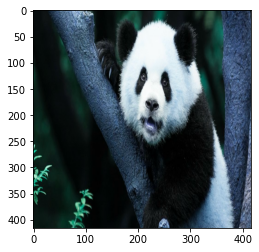

In [40]:
import matplotlib.pyplot as plt
plt.imshow(image)

In [41]:
prediction = yolo.predict(np.array([image]))
print(prediction)

(array([[[ 0.35170203,  0.04091653,  0.9331091 ,  0.9862201 ],
        [-0.16564159, -0.01799741,  0.25371262,  0.10954715],
        [-0.16564159, -0.01799741,  0.25371262,  0.10954715],
        [-0.16564159, -0.01799741,  0.25371262,  0.10954715],
        [-0.16564159, -0.01799741,  0.25371262,  0.10954715],
        [-0.16564159, -0.01799741,  0.25371262,  0.10954715],
        [-0.16564159, -0.01799741,  0.25371262,  0.10954715],
        [-0.16564159, -0.01799741,  0.25371262,  0.10954715],
        [-0.16564159, -0.01799741,  0.25371262,  0.10954715],
        [-0.16564159, -0.01799741,  0.25371262,  0.10954715],
        [-0.16564159, -0.01799741,  0.25371262,  0.10954715],
        [-0.16564159, -0.01799741,  0.25371262,  0.10954715],
        [-0.16564159, -0.01799741,  0.25371262,  0.10954715],
        [-0.16564159, -0.01799741,  0.25371262,  0.10954715],
        [-0.16564159, -0.01799741,  0.25371262,  0.10954715],
        [-0.16564159, -0.01799741,  0.25371262,  0.10954715],
       

0.35170203
0.040916532
0.9331091
0.9862201
0.94530356
0.58140707


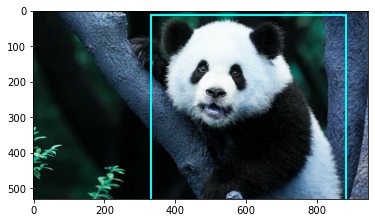

In [42]:
#Localización

x1=(prediction[0][0][0][0])
y1=(prediction[0][0][0][1])
x2=(prediction[0][0][0][2])
y2=(prediction[0][0][0][3])

h=y2-y1
w=x2-x1


print(x1)
print(y1)
print(x2)
print(y2)
print(h)
print(w)

import matplotlib.patches as patches
from PIL import Image

plt.imshow(im)

ax = plt.gca()

rect = patches.Rectangle((x1*944 #x1
                          ,y2*10), #y2'
                 w*944,#w
                 h*944, #h
                 linewidth=2,
                 edgecolor='cyan',
                 fill = False)


ax.add_patch(rect)

plt.show()

In [43]:
#algunas proporciones (calculos propios)

y2*44
x1*78.44
530*0.7849
p1=1/0.7849
p1
944*0.4407
p2=1/0.4407
p2

2.269117313365101

#### Prueba y evaluación del modelo
___

- Probaremos el modelo en las siguientes imagenes en complejidad creciente llamando a las funciones

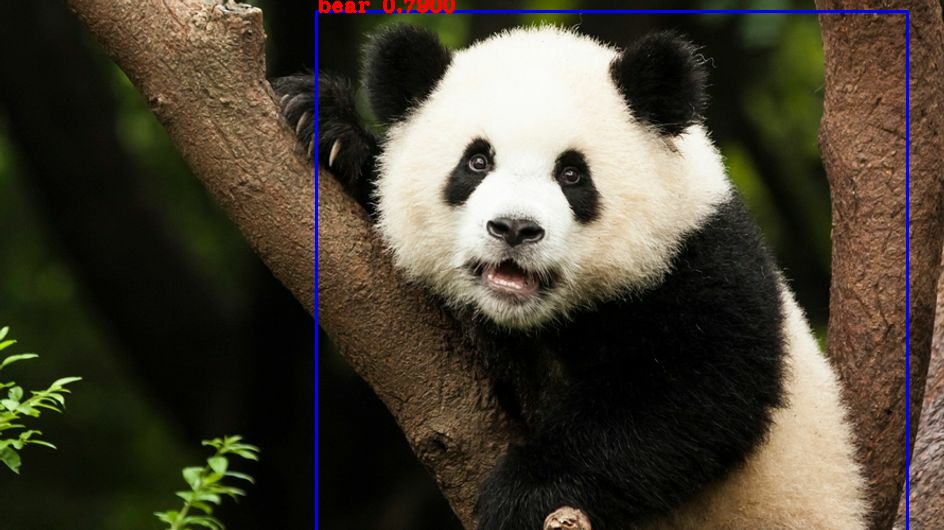

In [44]:
path_img = r'C:\Users\pablo.cumbrera\Downloads\yolov3-tf2-master\yolov3-tf2-master\data\panda.jpg'
mainA(path_img)
from IPython.display import Image
Image(filename=r'C:\Users\pablo.cumbrera\Downloads\yolov3-tf2-master\yolov3-tf2-master\outputs\output.jpg') 

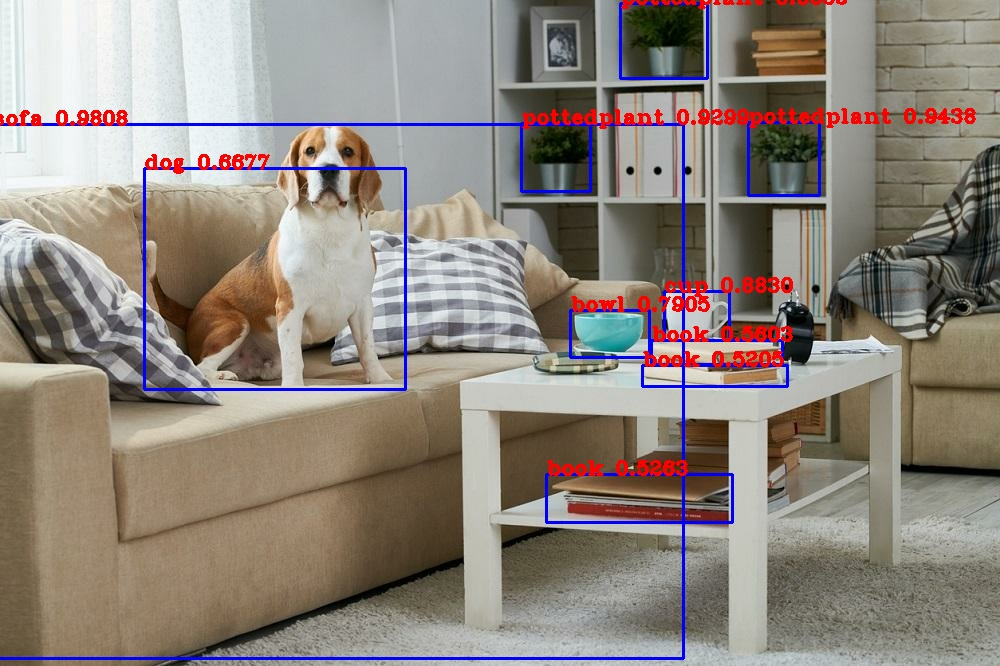

In [45]:
path_img = r'C:\Users\pablo.cumbrera\Downloads\yolov3-tf2-master\yolov3-tf2-master\data\perro-casa.jpg'
mainA(path_img)
from IPython.display import Image
Image(filename=r'C:\Users\pablo.cumbrera\Downloads\yolov3-tf2-master\yolov3-tf2-master\outputs\output.jpg') 

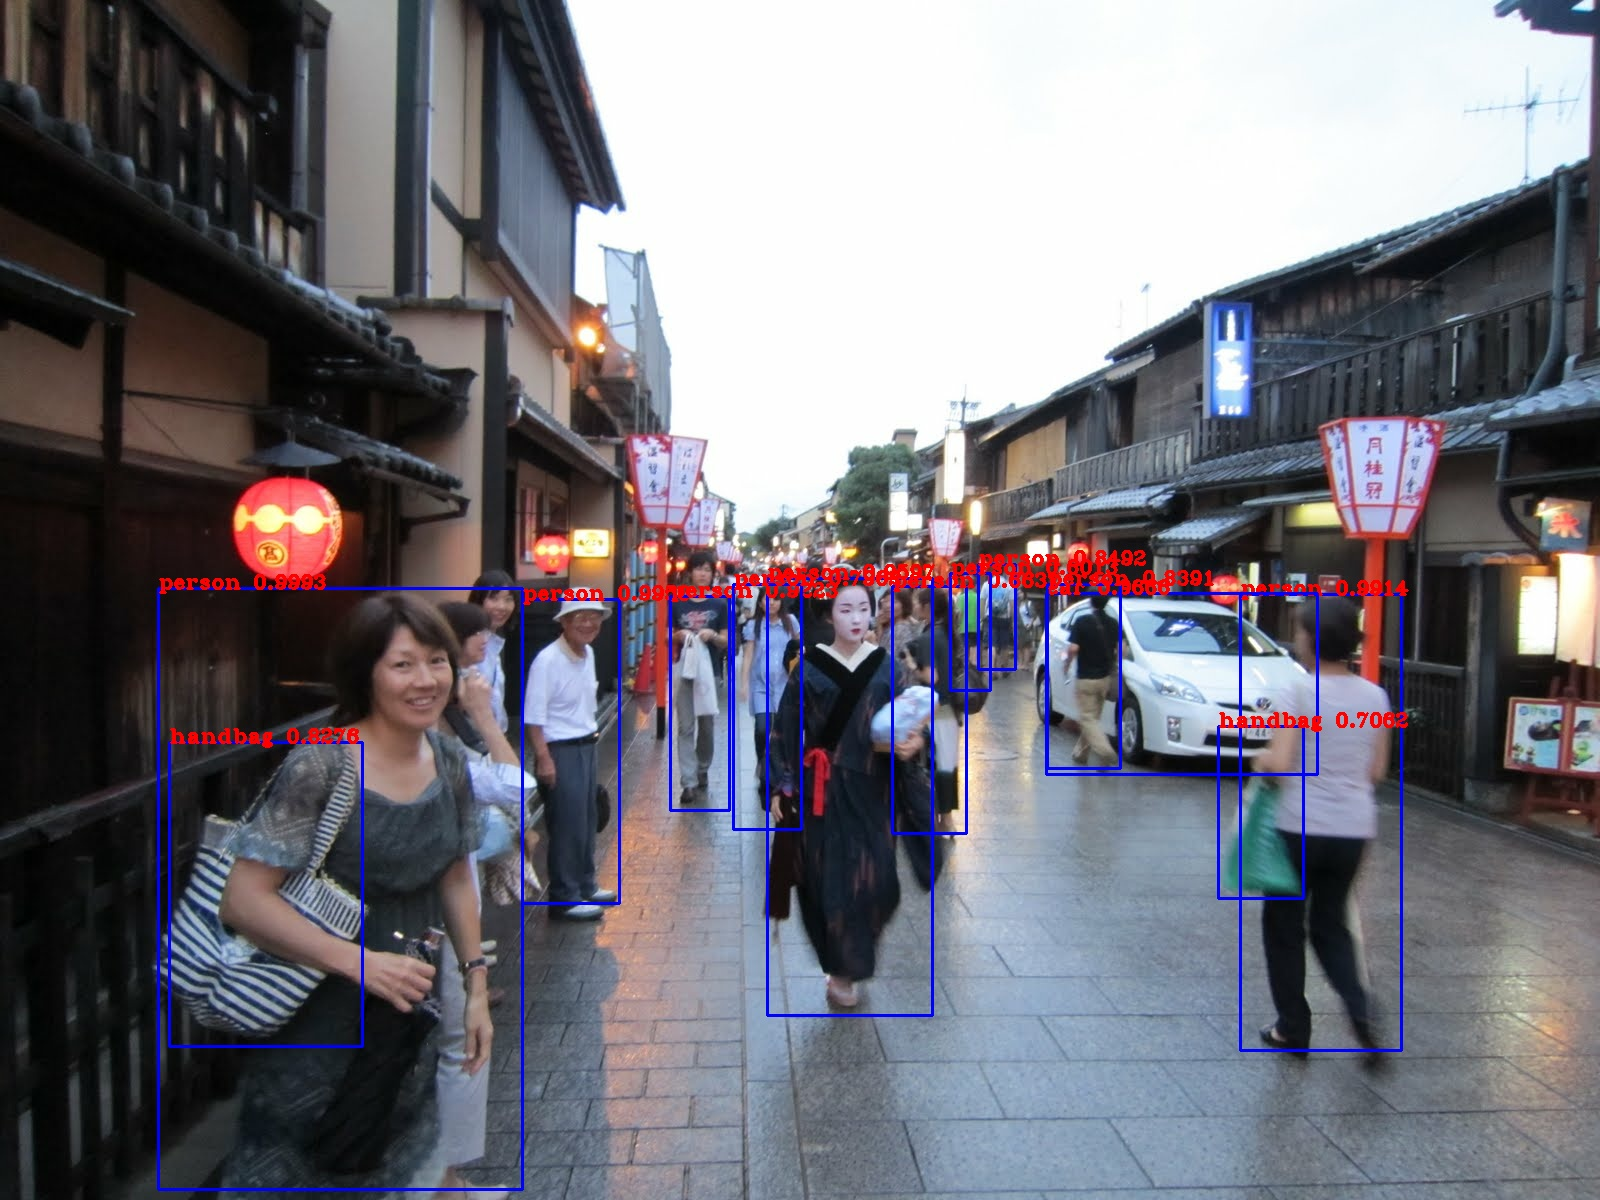

In [46]:
path_img = r'C:\Users\pablo.cumbrera\Downloads\yolov3-tf2-master\yolov3-tf2-master\data\kyoto-gion.jpg'
mainA(path_img)
from IPython.display import Image
Image(filename=r'C:\Users\pablo.cumbrera\Downloads\yolov3-tf2-master\yolov3-tf2-master\outputs\output.jpg') 

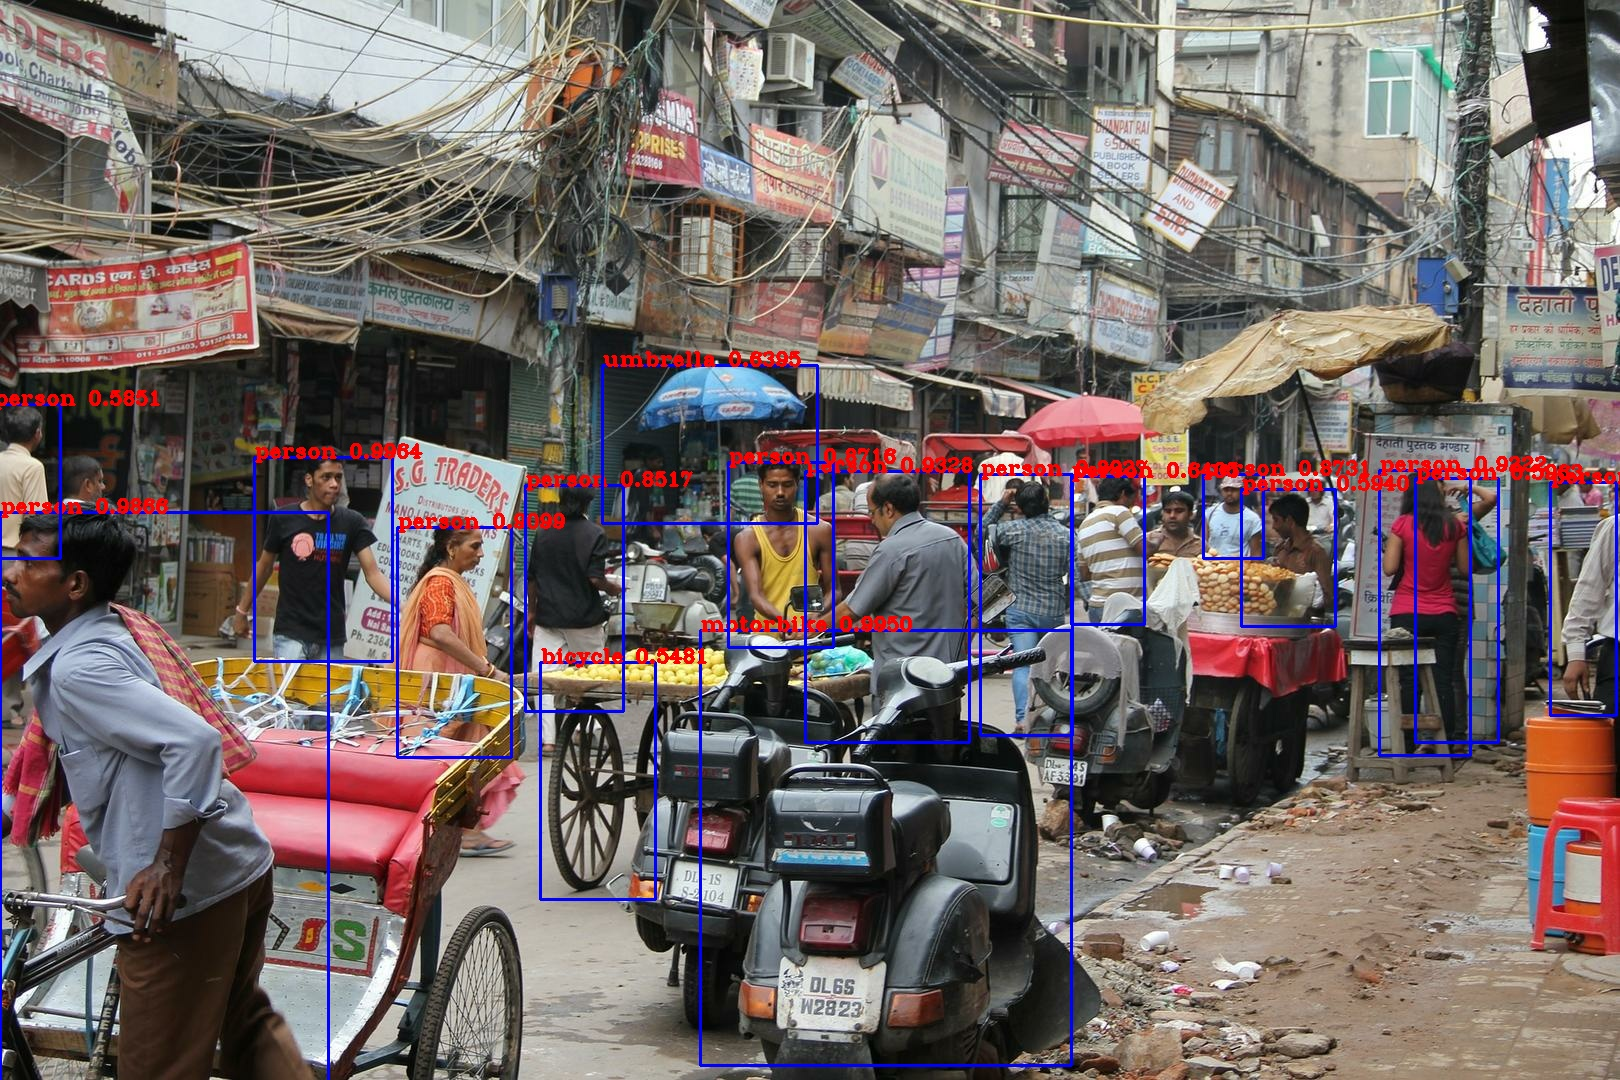

In [47]:
path_img = r'C:\Users\pablo.cumbrera\Downloads\yolov3-tf2-master\yolov3-tf2-master\data\delhi-por-carretera-la-india.jpg'
mainA(path_img)
from IPython.display import Image
Image(filename=r'C:\Users\pablo.cumbrera\Downloads\yolov3-tf2-master\yolov3-tf2-master\outputs\output.jpg') 

- Detección de video

In [49]:
path_video= r'C:\Users\pablo.cumbrera\Downloads\yolov3-tf2-master\yolov3-tf2-master\data\video2.mp4'
mainC(path_video)
from IPython.display import Video
Video(r"C:\Users\pablo.cumbrera\Downloads\yolov3-tf2-master\yolov3-tf2-master\outputs\video-output.mp4")

W0525 10:04:45.666697  8880 <ipython-input-28-e6086af6d14e>:38] Empty Frame
W0525 10:04:45.776410  8880 <ipython-input-28-e6086af6d14e>:38] Empty Frame
W0525 10:04:45.887305  8880 <ipython-input-28-e6086af6d14e>:38] Empty Frame
W0525 10:04:45.997787  8880 <ipython-input-28-e6086af6d14e>:38] Empty Frame
W0525 10:04:46.108144  8880 <ipython-input-28-e6086af6d14e>:38] Empty Frame
W0525 10:04:46.218046  8880 <ipython-input-28-e6086af6d14e>:38] Empty Frame
W0525 10:04:46.327748  8880 <ipython-input-28-e6086af6d14e>:38] Empty Frame
W0525 10:04:46.438094  8880 <ipython-input-28-e6086af6d14e>:38] Empty Frame
W0525 10:04:46.547890  8880 <ipython-input-28-e6086af6d14e>:38] Empty Frame
W0525 10:04:46.658102  8880 <ipython-input-28-e6086af6d14e>:38] Empty Frame
W0525 10:04:46.769469  8880 <ipython-input-28-e6086af6d14e>:38] Empty Frame
W0525 10:04:46.880519  8880 <ipython-input-28-e6086af6d14e>:38] Empty Frame
W0525 10:04:46.990190  8880 <ipython-input-28-e6086af6d14e>:38] Empty Frame
W0525 10:04:

KeyboardInterrupt: 

##########################################################################################################################
____